In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# konlpy 설치
! pip install konlpy
# pyLDAvis 설치
!pip install pyLDAvis

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [ ]:
# 사용할 패키지 선언
import requests
from bs4 import BeautifulSoup
import time
import csv

import pandas as pd
import numpy as np

import os, re
from tqdm import tqdm

from konlpy.utils import pprint
from konlpy.tag import Okt

# 경고문구 미표시
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 지정
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 사이킷런 패키지 활용
from sklearn.decomposition import LatentDirichletAllocation

import torchtext

# 사이킷런 패키지 활용
from sklearn.feature_extraction.text import TfidfVectorizer

import pyLDAvis

# 사이킷런 패키지 활용
from sklearn.linear_model import LogisticRegression

from wordcloud import WordCloud
import PIL

In [ ]:
# 변수들 선언
pages = 1000
need_reviews_cnt = 1000
reviews = []
review_data=[]

for page in range(1,pages):
    url = f'https://movie.naver.com/movie/point/af/list.naver?&page={page}'
    #get : request로 url의  html문서의 내용 요청
    html = requests.get(url)
    #html을 받아온 문서를 .content로 지정 후 soup객체로 변환
    soup = BeautifulSoup(html.content,'html.parser')
    #find_all : 지정한 태그의 내용을 모두 찾아 리스트로 반환
    reviews = soup.find_all("td",{"class":"title"})

    #한 페이지의 리뷰 리스트의 리뷰를 하나씩 보면서 데이터 추출
    for review in reviews:
        sentence = review.find("a",{"class":"report"}).get("onclick").split("', '")[2]
        #만약 리뷰 내용이 비어있다면 데이터를 사용하지 않음
        if sentence != "":
            movie = review.find("a",{"class":"movie color_b"}).get_text()
            score = review.find("em").get_text()
            review_data.append([movie,sentence,int(score)])
            need_reviews_cnt-= 1
    #현재까지 수집된 리뷰가 목표 수집 리뷰보다 많아진 경우 크롤링 중지
    if need_reviews_cnt < 0:
        break
    #다음 페이지를 조회하기 전 0.5초 시간 차를 두기
    time.sleep(0.5)

# csv 파일로 저장
columns_name = ["movie","sentence","score"]
with open ( "samples.csv", "w", newline ="",encoding = 'utf8' ) as f:
    write = csv.writer(f)
    write.writerow(columns_name)
    write.writerows(review_data)

In [ ]:
# 다운로드 받을 폴더를 준비
DATA_DIR = "./data"
os.makedirs(DATA_DIR, exist_ok=True)


torchtext.utils.download_from_url(url='https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt',
                                  path=os.path.join(DATA_DIR, 'review.txt'))

'/content/data/review.txt'

In [ ]:
# txt 파일을 판다스 데이터프레임으로 읽어오기
data = pd.read_csv(os.path.join(DATA_DIR, 'review.txt'), sep='\t')

# 데이터프레임의 크기
print(data.shape)

data

(150000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [ ]:
# 긍정 리뷰를 하나 선택
sample_text = data['document'].iloc[381]
print(type(sample_text))
print(sample_text)

<class 'str'>
진짜 어마어마한 여운을 주는 멜로 영화에요.ㅎ


In [ ]:
# 트위터 형태소 분석기(Okt)를 활용
okt = Okt()
print(okt)

In [ ]:
# (단어, 품사) 추출
tokens = okt.pos(sample_text)
pprint(tokens)

[('진짜', 'Noun'),
 ('어마어마한', 'Adjective'),
 ('여운', 'Noun'),
 ('을', 'Josa'),
 ('주는', 'Verb'),
 ('멜로', 'Noun'),
 ('영화', 'Noun'),
 ('에요', 'Josa'),
 ('.', 'Punctuation'),
 ('ㅎ', 'KoreanParticle')]


In [ ]:
# (단어, 품사) 추출
tokens = okt.pos(sample_text)
pprint(tokens)

[('진짜', 'Noun'),
 ('어마어마한', 'Adjective'),
 ('여운', 'Noun'),
 ('을', 'Josa'),
 ('주는', 'Verb'),
 ('멜로', 'Noun'),
 ('영화', 'Noun'),
 ('에요', 'Josa'),
 ('.', 'Punctuation'),
 ('ㅎ', 'KoreanParticle')]


In [ ]:
# (단어, 품사) 추출
tokens = okt.pos(sample_text)
pprint(tokens)

[('진짜', 'Noun'),
 ('어마어마한', 'Adjective'),
 ('여운', 'Noun'),
 ('을', 'Josa'),
 ('주는', 'Verb'),
 ('멜로', 'Noun'),
 ('영화', 'Noun'),
 ('에요', 'Josa'),
 ('.', 'Punctuation'),
 ('ㅎ', 'KoreanParticle')]


In [ ]:
# 단어 ONLY 추출
tokens = okt.morphs(sample_text)
pprint(tokens)

['진짜', '어마어마한', '여운', '을', '주는', '멜로', '영화', '에요', '.', 'ㅎ']


In [ ]:
# 명사 ONLY 추출
tokens = okt.nouns(sample_text)
pprint(tokens)

['진짜', '여운', '멜로', '영화']


In [ ]:
# 누락 데이터를 제거
review_data = data['document'].dropna().values

#10000개의 샘플을 선택하여 추출
review_data = review_data[:10000]

# 배열의 크기
print(review_data.shape)

# 첫 번째 데이터
print(review_data[0])

(10000,)
아 더빙.. 진짜 짜증나네요 목소리


In [ ]:
# 세 글자 이상의 명사를 사용 (두 글자 이하의 단어는 제거)
cleaned_review_data = []

for review in tqdm(review_data):
    tokens = okt.nouns(review)
    cleaned_tokens = []
    for word in tokens:
        if len(word) > 2:
            cleaned_tokens.append(word)
        else:
            pass
    cleaned_review = " ".join(cleaned_tokens)
    cleaned_review_data.append(cleaned_review)

print(len(cleaned_review_data))
print(cleaned_review_data[0])

100%|██████████| 10000/10000 [00:40<00:00, 243.97it/s]

10000
목소리


In [ ]:
# TF-IDF 변환기 객체를 생성
tfid = TfidfVectorizer()

# TF-IDF 변환기에 데이터를 입력하여 변환
review_tfid = tfid.fit_transform(cleaned_review_data)

# 배열의 크기
print(review_tfid.shape)

# 첫 번째 데이터
print(review_tfid[0])

(10000, 3477)
  (0, 955)	1.0


In [ ]:
# 단어 사전 확인 (딕셔너리 형태)
vocab = tfid.vocabulary_

# 단어 사전의 크기
print(len(vocab))

# 단어 사전 출력 (앞에서 5개의 단어만 출력)
print({ k:v for i, (k, v) in enumerate(vocab.items()) if i < 5 })

3477
{'목소리': 955, '포스터': 3194, '교도소': 194, '이야기': 2329, '스파이더맨': 1623}


In [ ]:
# 단어들의 사전 인덱스를 이용하여 원래 단어를 검색하는 매핑 딕셔너리
index_to_word = { v:k for k, v in vocab.items() }

# 앞에서 5개의 단어를 출력
print({  k:v for i, (k, v) in enumerate(index_to_word.items()) if i < 5 })

{955: '목소리', 3194: '포스터', 194: '교도소', 2329: '이야기', 1623: '스파이더맨'}


In [ ]:
# 단어들의 사전 인덱스를 이용하여 원래 단어를 검색하는 매핑 딕셔너리
index_to_word = { v:k for k, v in vocab.items() }

# 앞에서 5개의 단어를 출력
print({  k:v for i, (k, v) in enumerate(index_to_word.items()) if i < 5 })

{955: '목소리', 3194: '포스터', 194: '교도소', 2329: '이야기', 1623: '스파이더맨'}


In [ ]:
# 첫 번째 리뷰를 구성하는 단어들의 사전 인덱스를 이용하여 원래 단어를 복원 (순서 복원 X)
original_text = " ".join([index_to_word[word_idx] for word_idx in review_tfid[0].indices])
original_text

'목소리'

In [ ]:
# 첫 번째 리뷰를 구성하는 단어들의 사전 인덱스를 이용하여 원래 단어를 복원 (순서 복원 X)
original_text = " ".join([index_to_word[word_idx] for word_idx in review_tfid[0].indices])
original_text

'목소리'

In [ ]:
# LDA 모델링 객체를 생성 (토픽 갯수를 2로 설정: 긍정/부정)
lda = LatentDirichletAllocation(n_components=2)

# TF-IDF 벡터를 입력하여 모델 학습
lda.fit(review_tfid)

LatentDirichletAllocation(n_components=2)

In [ ]:
# 토픽 모델링 결과를 담고 있는 배열의 형태 : (2개의 토픽, 2157개의 단어)
print(lda.components_.shape)

(2, 3477)


In [ ]:
#토픽 별로 가장 중요도가 높은 단어를 10개씩 출력

for idx, topic in enumerate(lda.components_):
    print(f"토픽 유형 {idx+1}:", [(index_to_word[i], topic[i].round(3)) for i in topic.argsort()[:-11:-1]])

토픽 유형 1: [('드라마', 189.339), ('마지막', 107.698), ('이영화', 79.67), ('시리즈', 41.736), ('스릴러', 37.108), ('긴장감', 36.04), ('연기력', 34.767), ('캐스팅', 28.796), ('도대체', 27.786), ('시나리오', 27.444)]
토픽 유형 2: [('스토리', 217.043), ('쓰레기', 143.082), ('주인공', 100.456), ('이야기', 97.919), ('코미디', 55.174), ('캐릭터', 41.393), ('포스터', 38.976), ('한국영', 37.5), ('공포영화', 34.386), ('최고다', 32.436)]


In [ ]:
# LDA 토픽 모델링 결과를 시각화
pyLDAvis.enable_notebook()
visualization = pyLDAvis.sklearn.prepare(lda, review_tfid, tfid)
pyLDAvis.display(visualization)

In [ ]:
labels = data['label'].iloc[:10000].values
print(labels.shape)
print(labels[:5])

(10000,)
[0 1 0 0 1]


In [ ]:
# 로지스틱 분류 모델링 객체를 생성
lr = LogisticRegression()

# TF-IDF 벡터를 입력하여 모델 학습
lr.fit(review_tfid, labels)

LogisticRegression()

In [ ]:
# 첫 번째 샘플을 이용하여 모델 예측
pred = lr.predict(review_tfid[0])
print(pred)

[0]


In [ ]:
# 판다스 데이터프레임로 읽어오기
test = pd.read_csv('samples.csv')

# 결측치 제거
test.dropna()

print(test['movie'].unique())

['타이타닉' '애프터썬' '하모니' '굿바이 마이 프랜드' '다음 소희' '교섭' '더 퍼스트 슬램덩크' '인피에스토'
 '맘마미아!' '아미 오브 더 데드' '유령' '상견니' '우리 사랑이 향기로 남을 때' '바빌론' '영웅' '메모리아' '베놈'
 '아바타: 물의 길' '나는 나를 해고하지 않는다' '스위치' '만인의 연인' 'RRR: 라이즈 로어 리볼트'
 '궁지에 몰린 쥐는 치즈 꿈을 꾼다' '성스러운 거미' '갱' '마이웨이' '고질라 VS. 콩' '어쩌면 우린 헤어졌는지 모른다'
 '아이리시맨' '가재가 노래하는 곳' '네가 떨어뜨린 푸른 하늘' '리멤버' '크로우즈 제로 2' '이상한 나라의 수학자'
 '기방도령' '영화 크레용 신짱: 폭풍을 부르는 모레츠! 오토나 제국의 역습' '토르: 러브 앤 썬더' '산상수훈' '멋진 하루'
 '곡성(哭聲)' '자백' '협상' '오늘 밤, 세계에서 이 사랑이 사라진다 해도' '첼로 - 홍미주 일가 살인사건'
 '당신, 거기 있어줄래요' '신의 분노' '디텍티브 나이트: 가면의 밤' '원피스 필름 레드' '창수' '쌍화점' '아저씨'
 '패닉 런' '헤어질 결심' '올빼미' '그대가 조국' '#살아있다' '블랙 팬서: 와칸다 포에버' '뷰티풀 마인드'
 '그래도 좋아해' '메간' '앰뷸런스' '트윈' '샹치와 텐 링즈의 전설' '늑대와 춤을' '브이 포 벤데타' '헬보이'
 '내부자들' '스펜서' '트루 스피릿' '패싱' '킬 유어 달링' '국제시장' '지푸라기라도 잡고 싶은 짐승들' '레미니센스'
 '세자매' '아수라' '서복' '시간이탈자' '우리들의 일기' '기적' '소녀' '극장판 귀멸의 칼날: 무한열차편' '범죄도시2'
 '주토피아' '씽2게더' '귀못' '동감' '맨 인 블랙: 인터내셔널' '너의 이름은.' '장화신은 고양이: 끝내주는 모험'
 '두번째 사랑' '창공으로' '미라클 프롬 헤븐' '시라노; 연애조작단' '언니가 간다' '해시태그 시그네' '문폴'
 '게임의 법칙' '라이언 일병 구하

In [ ]:
# 워드 클라우드에 사용할 명사
nouns = []

def Analyze(test_sample):
  global po_cnt
  # 한글을 제외하고 전부 제거
  test_sample = re.sub(r"[^가-힣]", "", test_sample)

  # 세 글자 이상의 명사만을 추출
  tokens = okt.nouns(test_sample)
  cleaned_tokens = []
  for word in tokens:
      nouns.append(word)
      if len(word) > 2:
          cleaned_tokens.append(word)
      else:
          pass
  cleaned_review = " ".join(cleaned_tokens)
  # TF-IDF 변환기에 데이터를 입력하여 변환
  test_review_tfid = tfid.transform([cleaned_review])

  # 로지스틱 회귀 모델을 활용하여 분류 예측
  test_pred = lr.predict(test_review_tfid)[0]
  if test_pred > 0:
    response = "긍정"
    po_cnt += 1
  else:
    response = "부정"
  print("-분석 결과 {}적인 리뷰로 예측됩니다.-\n".format(response))
'''
name = input("영화 제목을 입력해주세요.")
po_cnt = 0
cnt = 0

for test_sample in test.loc[test['movie'] == name,'sentence']:
  cnt += 1
  print(test_sample)
  Analyze(test_sample)

if po_cnt > (cnt - po_cnt):
  print(f"{name} 영화는 긍적적인 리뷰가 많습니다.")
elif po_cnt < (cnt - po_cnt):
  print(f"{name} 영화는 부정적인 리뷰가 많습니다.")
else:
  print(f"{name} 영화는 긍적적인 리뷰와 부정적인 리뷰가 동등합니다.")'''

영화 제목을 입력해주세요.타이타닉
이 영화 안 본 눈 삽니다
-분석 결과 긍정적인 리뷰로 예측됩니다.-

몆년이 지나도 최고의 명작♡
-분석 결과 부정적인 리뷰로 예측됩니다.-

진짜 역시 명작은 명작이라고 불리는 이유가 있습니다.... 꼭 IMAX로 관람하시길 바랍니다.
-분석 결과 긍정적인 리뷰로 예측됩니다.-

타이타닉 디카프리오 케이트윈슬렛 사랑해
-분석 결과 긍정적인 리뷰로 예측됩니다.-

깊고 푸른 바다에 버려요, 아직도 숨 쉬고 있는 잭 그리고 음악이 끝나지 않는 타이타닉이 잠겨있는 그 곳에...
-분석 결과 긍정적인 리뷰로 예측됩니다.-

긴 말 안함 최고였음
-분석 결과 긍정적인 리뷰로 예측됩니다.-

역대 최고의 명작이에요 ㅠ 인생영화입니다 ..극장에서 볼수 있음에 그저 감사..
-분석 결과 긍정적인 리뷰로 예측됩니다.-

기어코 내 마음도 같이 가라앉아버렸네. 
-분석 결과 긍정적인 리뷰로 예측됩니다.-

명작은 몇 번을 봐도 또 다시 찾게 되는 것같다..
-분석 결과 긍정적인 리뷰로 예측됩니다.-

타이타닉 존버타다 드디어 오늘 봤다.. 후회 안해 그냥 미쳤다.
-분석 결과 긍정적인 리뷰로 예측됩니다.-

3D가 최고의 결함이다
-분석 결과 긍정적인 리뷰로 예측됩니다.-

제임스 카메론의 연출이 대단한 영화
-분석 결과 긍정적인 리뷰로 예측됩니다.-

모든게 완벽하다 이 이상으로 말 못하겠음
-분석 결과 긍정적인 리뷰로 예측됩니다.-

별점 10개가 최대? 더가져와요 더 눈 밤톨이 되기 딱 좋은 영화 너무 재미써요 ㅠㅠ
-분석 결과 긍정적인 리뷰로 예측됩니다.-

정말 행복한 3시간이었어요. 제가 할 수 있는 최고의 찬사로 축복하고 싶은 영화였습니다. 배우들의 연기와 연출력은 말할 것도 없이 훌륭했고요. 러닝타임이 긴 영화는 지루해서 힘겨운 적이 다반사였지만 전혀 지루하지 않고 재밌게 관람한 영화였습니다. 이걸 극장에서 처음보게 되어 너무 좋았어요. 며칠 뒤 다시 볼 예정입니다. 휴대폰으로 보기엔 너무 아쉬운 영화.
-분석 결과 긍정적인 

In [ ]:
# 명사 데이터 프레임으로 변환
df_word = pd.DataFrame({'word' : nouns})

# 글자 수 추가
df_word['count'] = df_word['word'].str.len()

# 두 글자 이상 단어만 남기기
df_word = df_word.query('count >= 2')
df_word.sort_values('count')

# 단어 빈도 구하기
df_word = df_word.groupby('word', as_index = False).agg(n = ('word', 'count')).sort_values('n', ascending = False)

# 데이터 프레임을 딕셔너리로 변환

dic_word = df_word.set_index('word').to_dict ()['n']

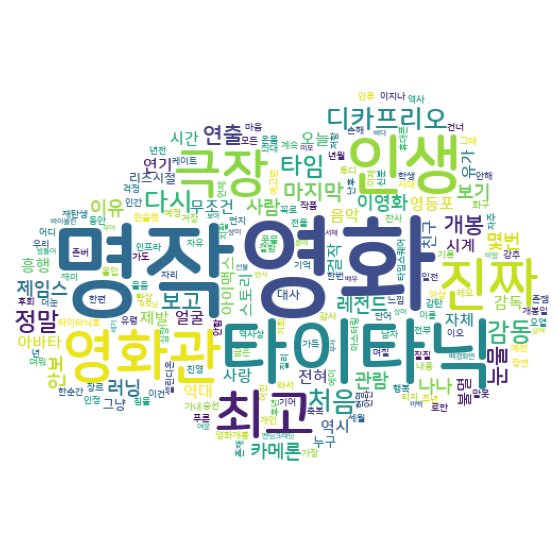

In [ ]:
# 폰트와 클라우드 icon지정
font = 'NanumSquareRoundB.ttf'
icon = PIL.Image.open('free-icon-cloud-796091.png')

img = PIL.Image.new('RGB', icon.size, (255, 255, 255))
img.paste(icon, icon)
img = np.array(img)

# 워드 클라우드 객체생성
wc = WordCloud(random_state= 1234, width = 400, height = 400, font_path = font, background_color= 'white', mask = img)

# 워드 클라우드 만들기
img_wordcloud = wc.generate_from_frequencies(dic_word)

# 워드 클라우드 출력하기
plt.figure(figsize = (10, 10))
plt.axis('off')
plt.imshow(img_wordcloud)
